In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sea 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.patches as mpatches

import pandasdmx as sdmx                 # $pip install pandasdmx

C:\Users\jaeco\AppData\Roaming\Python\Python37\site-packages\pandasdmx\remote.py:14: RuntimeWarning: optional dependency requests_cache is not installed; cache options to Session() have no effect
  RuntimeWarning,


In [2]:
# load data from OECD, using SDMX
      
# GDP growth rate
gdp_growth = sdmx.Request('OECD').data(
# resource: Quarterly National Accounts
  resource_id='QNA',
# JPN+KOR: Japan and Korea
# B1_GE: GDP-Expenditure Approach
# GPSA: growth rate compared to previous quarter, seasonally adjusted
# Q: quarterly
# all: load all available data
  key='JPN+KOR.B1_GE.GPSA.Q/all').write().reset_index()

# exports and imports of South Korea
exp_imp = sdmx.Request('OECD').data(
# resource: Quarterly National Accounts
  resource_id='QNA',
# KOR: Only Korea
# P6+P7: Exports of Goods and Services (P6) and Imports of Goods and Services (P7)  
# CQR: National Currency, current prices, quarterly levels
# Q: quarterly
# all: load all available data
  key='KOR.P6+P7.CQR.Q/all',
    params={'startTime': '1960-Q2'}).write().reset_index()



In [3]:
# make columns only have lower case names
gdp_growth.columns= gdp_growth.columns.str.lower()
exp_imp.columns= exp_imp.columns.str.lower()

# pivot 'gdpgrowth dataframe' to horizontally contain GDP growth rate variable
gdp_growth = gdp_growth.pivot(index='time_period', columns='location', values='value').reset_index()

# calculate log net exports, (ln_exports-ln_imports) 
# log values
exp_imp['ln_value'] = np.log2(exp_imp['value']) 
# change names (P6:exports, P7:imports)
exp_imp.subject = exp_imp.subject.map({ 'P6' : 'ln_exports', 'P7' : 'ln_imports'})
# pivot 'expimp dataframe' to horizontally contain exports and imports
exp_imp = exp_imp.pivot(index='time_period', columns='subject', values='ln_value').reset_index()
# calculate log net exports
exp_imp['ln_net_exports'] = exp_imp.ln_exports-exp_imp.ln_imports

In [4]:
# merge gdp_growth with exp_imp
df = pd.merge(gdp_growth, exp_imp)
# make JPN_shifted_40 column that contains Japan's GDP growth rate (shifted 10 years (40quarters))
df['JPN_shifted_40q'] = df['JPN'].shift(periods=40)
# make dataframe that only conatins GDP growth rates and log net exports
df1 = df[["JPN", "KOR","ln_net_exports"]]
# make dataframe that only conatins S. Korea's GDP growth rate, shifted Japan's GDP growth rate and log net exports
df2 = df[["JPN_shifted_40q", "KOR","ln_net_exports"]]

In [5]:
# summary statistics
df[["KOR","JPN","ln_imports","ln_exports", "ln_net_exports","JPN_shifted_40q"]].describe()

,KOR,JPN,ln_imports,ln_exports,ln_net_exports,JPN_shifted_40q
count,242.000000,242.000000,242.000000,242.000000,242.000000,202.000000
mean,1.758539,0.882421,22.554182,22.286438,-0.267745,1.045341
std,2.002239,1.453872,4.354758,4.900628,0.608425,1.323806
min,-6.818022,-8.261777,12.791570,10.670656,-2.265982,-4.812908
25%,0.717020,0.109616,19.673811,19.137347,-0.371969,0.188337
50%,1.591371,0.806993,23.590638,23.581937,-0.032618,0.956668
75%,2.888130,1.542979,26.262111,26.335379,0.113057,1.868284
max,8.061462,5.697546,27.515159,27.634817,0.469884,5.697546


In [6]:
# simple linear model 1 (S. Korea's GDP growth rate ~ Japan's GDP growth rate)
model1_results = smf.ols(formula = 'KOR ~ JPN', data = df1).fit()
model1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    KOR   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     11.51
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           0.000810
Time:                        08:24:59   Log-Likelihood:                -505.23
No. Observations:                 242   AIC:                             1014.
Df Residuals:                     240   BIC:                             1021.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4986      0.147     10.162      0.000       1.208       1.789
JPN            0.2946      0.087      3.392      0.001       0.124       0.466
==============================================================================
Omnibus:                       11.789   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               27.223
Skew:                          -0.027   Prob(JB):                     1.23e-06
Kurtosis:                       4.642   Cond. No.                         2.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Intercept    1.498588
JPN          0.294588
dtype: float64
<class 'pandas.core.series.Series'>


<function matplotlib.pyplot.show(*args, **kw)>

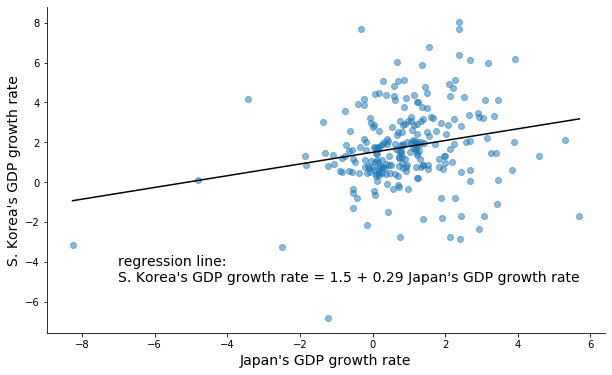

In [7]:
p1 = model1_results.params                                # params from the model fit
print(p1)
print(type(p1))
x1 = [df1['JPN'].min(), df1['JPN'].max()]
y1 = [p1.Intercept + p1.JPN*i for i in x1]   

fig, ax = plt.subplots(figsize=(10,6))

# Plot the data
ax.scatter(df1['JPN'], df1['KOR'], marker='o', alpha = 0.5 )
# Plot the regression line.
ax.plot(x1,y1, color='black')
# build the string
text = "regression line: \nS. Korea's GDP growth rate = {0:.2} + {1:.2} Japan's GDP growth rate".format(p1.Intercept, p1.JPN)
# text on the plot
ax.text(-7, -5, text, fontsize=14)
ax.set_xlabel("Japan's GDP growth rate", fontsize=14)
ax.set_ylabel("S. Korea's GDP growth rate", fontsize=14)
sea.despine(ax=ax)

plt.savefig('a.svg')
plt.show

# reference: ols.ipynb

In [8]:
# simple linear model 2 (S. Korea's GDP growth rate ~ 10 years (40 quarters) shifted Japan's GDP growth rate)
model2_results = smf.ols(formula = 'KOR ~ JPN_shifted_40q', data = df2).fit()
model2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    KOR   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     10.59
Date:                Fri, 11 Dec 2020   Prob (F-statistic):            0.00134
Time:                        08:25:00   Log-Likelihood:                -394.70
No. Observations:                 202   AIC:                             793.4
Df Residuals:                     200   BIC:                             800.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.3446      0.154      8.731      0.000       1.041       1.648
JPN_shifted_40q     0.2975      0.091      3.254      0.001       0.117       0.478
==============================================================================
Omnibus:                       35.724   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.693
Skew:                          -0.543   Prob(JB):                     1.28e-35
Kurtosis:                       7.232   Cond. No.                         2.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Intercept          1.344559
JPN_shifted_40q    0.297516
dtype: float64
<class 'pandas.core.series.Series'>


<function matplotlib.pyplot.show(*args, **kw)>

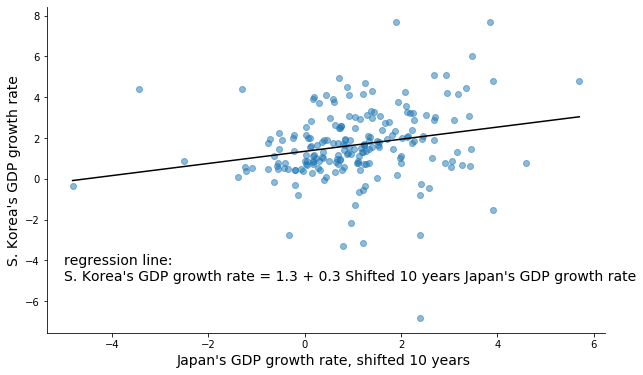

In [9]:
# model2 plot

p2 = model2_results.params                                # params from the model fit
print(p2)
print(type(p2))
x2 = [df2['JPN_shifted_40q'].min(), df2['JPN_shifted_40q'].max()]
y2 = [p2.Intercept + p2.JPN_shifted_40q*i for i in x2]   

fig1, ax1 = plt.subplots(figsize=(10,6))

# Plot the data
ax1.scatter(df2['JPN_shifted_40q'], df2['KOR'], marker='o', alpha = 0.5 )
# Plot the regression line.
ax1.plot(x2,y2, color='black')
# build the string
text = "regression line: \nS. Korea's GDP growth rate = {0:.2} + {1:.2} Shifted 10 years Japan's GDP growth rate".format(p2.Intercept, p2.JPN_shifted_40q)
# text on the plot
ax1.text(-5, -5, text, fontsize=14)
ax1.set_xlabel("Japan's GDP growth rate, shifted 10 years ", fontsize=14)
ax1.set_ylabel("S. Korea's GDP growth rate", fontsize=14)
sea.despine(ax=ax1)

plt.savefig('b.svg')
plt.show

# reference: ols.ipynb

In [10]:
# model 3, S. Korea's GDP growth rate = beta0 + beta1*ln_net_exports+beta2*Japan's GDP growth rate
#                                       + beta3*Japan's GDP growth rate(one quarter ago)
#                                       + ...
#                                       + beta42*Japan's GDP growth rate(40 quarters ago)+errorterm

# duplicate df1 
df3=df1
# make columns that contains i quarter ago's Japan's GDP growth rate
for i in range(1,41):
    df3["%s_%s_%s_%s"%('JPN','shifted',i,'quarters')] = df3['JPN'].shift(i)

# make string format formula for regression
# make list that contains column names of i quarter ago's Japan's GDP growth rate
list_shift = ["%s_%s_%s_%s"%('JPN','shifted',i,'quarters') for i in range(1, 41)]
# put plus sign between column names
string_shift_with_plus = '+'.join(list_shift)
# formula1 = 'KOR ~ ln_net_exports+JPN+JPN_shifted_1_quarters+...+JPN_shifted_40_quarters'
formula1= 'KOR ~ ln_net_exports+JPN+'
formula1 += string_shift_with_plus

# regression
model3_results = smf.ols(formula = formula1, data = df3).fit()
model3_results.summary()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    KOR   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     2.036
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           0.000892
Time:                        08:25:00   Log-Likelihood:                -356.45
No. Observations:                 202   AIC:                             798.9
Df Residuals:                     159   BIC:                             941.2
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.6606      0.228      2.896      0.004       0.210       1.111
ln_net_exports              0.9253      0.639      1.448      0.149      -0.336       2.187
JPN                         0.2858      0.099      2.873      0.005       0.089       0.482
JPN_shifted_1_quarters      0.1566      0.103      1.518      0.131      -0.047       0.360
JPN_shifted_2_quarters     -0.0292      0.120     -0.245      0.807      -0.265       0.207
JPN_shifted_3_quarters      0.2376      0.120      1.985      0.049       0.001       0.474
JPN_shifted_4_quarters      0.0693      0.120      0.578      0.564      -0.167       0.306
JPN_shifted_5_quarters     -0.1620      0.120     -1.355      0.177      -0.398       0.074
JPN_shifted_6_quarters     -0.0392      0.117     -0.333      0.739      -0.271       0.193
JPN_shifted_7_quarters     -0.1205      0.118     -1.022      0.309      -0.354       0.112
JPN_shifted_8_quarters      0.1226      0.118      1.039      0.301      -0.111       0.356
JPN_shifted_9_quarters     -0.0430      0.117     -0.366      0.715      -0.275       0.189
JPN_shifted_10_quarters    -0.0873      0.119     -0.732      0.465      -0.323       0.148
JPN_shifted_11_quarters    -0.0269      0.118     -0.228      0.820      -0.260       0.206
JPN_shifted_12_quarters     0.1000      0.119      0.844      0.400      -0.134       0.334
JPN_shifted_13_quarters    -0.0773      0.119     -0.650      0.517      -0.312       0.158
JPN_shifted_14_quarters     0.0513      0.121      0.423      0.673      -0.188       0.291
JPN_shifted_15_quarters     0.0390      0.121      0.322      0.748      -0.200       0.278
JPN_shifted_16_quarters     0.0135      0.122      0.111      0.912      -0.227       0.254
JPN_shifted_17_quarters    -0.0673      0.121     -0.555      0.580      -0.307       0.172
JPN_shifted_18_quarters     0.1944      0.123      1.575      0.117      -0.049       0.438
JPN_shifted_19_quarters     0.0891      0.123      0.727      0.468      -0.153       0.331
JPN_shifted_20_quarters    -0.0601      0.122     -0.492      0.624      -0.302       0.181
JPN_shifted_21_quarters     0.1659      0.121      1.373      0.172      -0.073       0.405
JPN_shifted_22_quarters    -0.0214      0.123     -0.174      0.862      -0.265       0.222
JPN_shifted_23_quarters     0.2158      0.124      1.747      0.083      -0.028       0.460
JPN_shifted_24_quarters     0.2554      0.124      2.066      0.040       0.011       0.499
JPN_shifted_25_quarters    -0.0653      0.122     -0.534      0.594      -0.307       0.177
JPN_shifted_26_quarters    -0.0212      0.125     -0.169      0.866      -0.269       0.226
JPN_shifted_27_quarters     0.0190      0.125      0.153      0.879      -0.227       0.265
JPN_shifted_28_quarters     0.0653      0.123  

1.3378049824019085


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


<function matplotlib.pyplot.show(*args, **kw)>

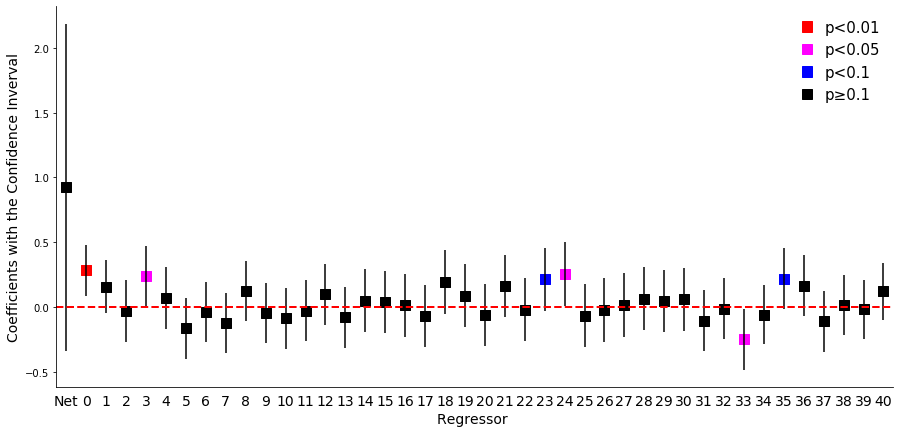

In [11]:
# model 3, coefficients plot
# generate error 
err_series = model3_results.params - model3_results.conf_int()[0]
# coef_df is dataframe that contains coefficients, error of coefficient, variable names, and pvalue
# exclude 'Intercept' from dataframe, by using [1:]
coef_df = pd.DataFrame({'coef': model3_results.params.values[1:],
                  'err': err_series.values[1:],
                  'varname': err_series.index.values[1:],
                  'pvalue': model3_results.pvalues[1:]})

# first, calculate and print sum of lag weights where lag weights are from JPN to JPN_shifted_40_quarters
print(coef_df.coef[1:42].sum())

# coefficients plot
fig2, ax2 = plt.subplots(figsize=(15, 7))

# plot confidence interval with the error, 'err'
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax2, color='none', 
             yerr='err', legend=False)

# remove x and y labels
ax2.set_ylabel('')
ax2.set_xlabel('')

# generate color list (p<0.01 : red, p<0.05 : magenta, p<0.1 : blue, others : black)
col =[] 
for i in range(0, 42): 
    if coef_df['pvalue'][i]>=0.1: 
        col.append('black')   
    elif coef_df['pvalue'][i]>=0.05:
        col.append('blue')
    elif coef_df['pvalue'][i]>=0.01:
        col.append('magenta')
    else:
        col.append('red')
        
# scatter plot of coefficients, (marker = square, color = col)
x=pd.np.arange(coef_df.shape[0])
for i in range(0, 42):
               ax2.scatter(x=x[i], y=coef_df['coef'][i], c = col[i], marker='s', s=100) 

# y=0 line
ax2.axhline(y=0, linestyle='--', color='red', linewidth=2)

# xticklabels
# N,0,1,2, ... , 38,39,40
tick=[]
for i in range(41):
    tick.append(str(i))
tick.insert(0,'Net')
ax2.xaxis.set_ticks_position('none')
_ = ax2.set_xticklabels(tick, rotation=0, fontsize=14)

# remove top and right axis
sea.despine(ax=ax2)

# generate legend
red_legend = mpatches.Patch(color='red', label='p<0.01')
magenta_legend = mpatches.Patch(color='magenta', label='p<0.05')
blue_legend = mpatches.Patch(color='blue', label='p<0.1')
black_legend = mpatches.Patch(color='black', label='p≥0.1')
plt.legend(handles=[red_legend,magenta_legend,blue_legend,black_legend], fontsize=15,frameon=False,handlelength=0.7)

# set labels
ax2.set_xlabel("Regressor ", fontsize=14)
ax2.set_ylabel("Coefficients with the Confidence Inverval", fontsize=14)

plt.savefig('c.svg')
plt.show

# reference: https://zhiyzuo.github.io/Python-Plot-Regression-Coefficient/
# reference: https://www.geeksforgeeks.org/mark-different-color-points-on-matplotlib/